In [9]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np

from flareTools import FINDflare, IRLSSpline

mpl.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix',
                            'image.cmap': 'viridis'})

In [10]:
path = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/sec7/'

# Flare star candidates that Jim picked out
f1 = 'tess2019006130736-s0007-0000000458616184-0131-s_lc.fits'
f2 = 'tess2019006130736-s0007-0000000458648813-0131-s_lc.fits'
f3 = 'tess2019006130736-s0007-0000000453002670-0131-s_lc.fits'

Text(0,0.5,'Flux [e-/s]')

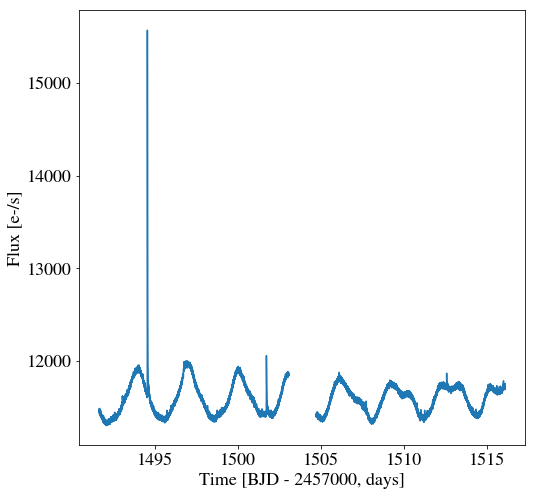

In [11]:
# Take a look at light curve #1
with fits.open(path+f1, mode='readonly') as hdulist:
    tess_bjds = hdulist[1].data['TIME']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_flux_error = hdulist[1].data['PDCSAP_FLUX_ERR']

    fig, axes = plt.subplots(figsize=(8,8))
axes.plot(tess_bjds, pdcsap_fluxes)
axes.set_xlabel('Time [BJD - 2457000, days]')
axes.set_ylabel('Flux [e-/s]')

In [12]:
# Throw out NaN fluxes
mask = ~np.isnan(pdcsap_fluxes)
time = tess_bjds[mask]
flux = pdcsap_fluxes[mask]
error = pdcsap_flux_error[mask]

In [13]:
# Identify flares using change point analysis function with rolling std
istart_i, istop_i = FINDflare(flux, error, avg_std=True)

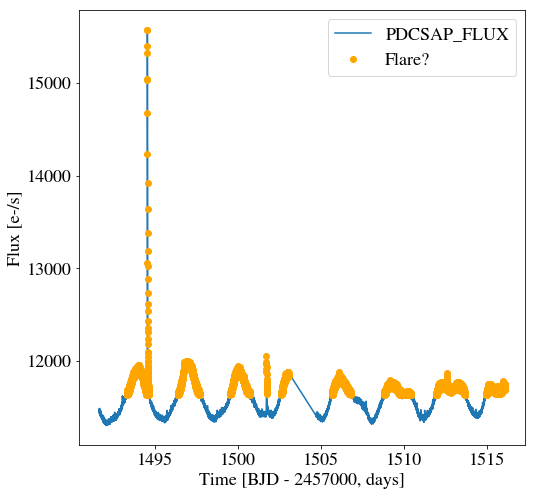

In [17]:
fig, axes = plt.subplots(figsize=(8,8))
axes.plot(time, flux, label='PDCSAP_FLUX')
axes.set_xlabel('Time [BJD - 2457000, days]')
axes.set_ylabel('Flux [e-/s]')

for idx in range(len((istart_i))):
    l = 'Flare?' if idx == 0 else '_nolabel_'
    axes.plot(time[istart_i[idx]:istop_i[idx]], flux[istart_i[idx]:istop_i[idx]], 'o', color='orange', label=l)
    
axes.legend()

In [20]:
# Now try an iterative re-weight least squares spline fit to
# detrend the light curve first
spline = IRLSSpline(time, flux, error)

Text(0,0.5,'Flux - Spline')

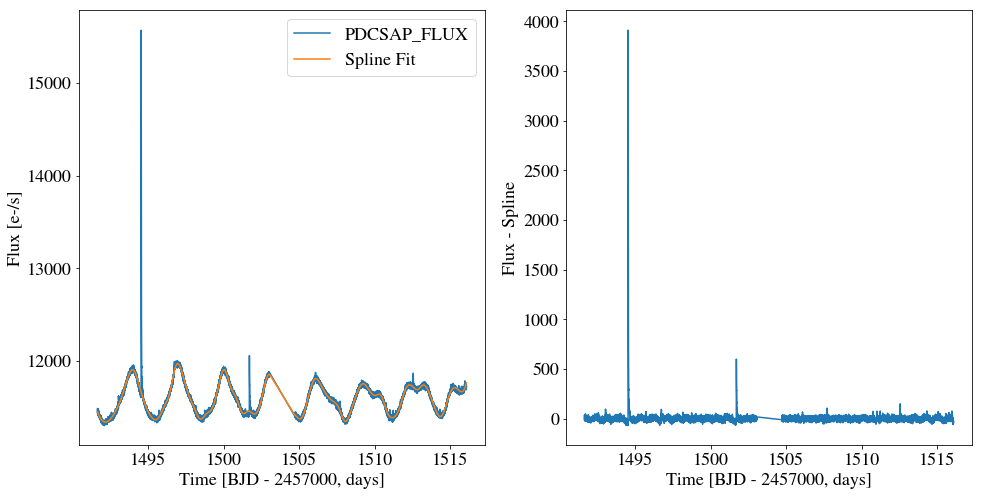

In [26]:
fig, axes = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
axes[0].plot(time, flux, label='PDCSAP_FLUX')
axes[0].plot(time, spline, label='Spline Fit')
axes[0].set_xlabel('Time [BJD - 2457000, days]')
axes[0].set_ylabel('Flux [e-/s]')
axes[0].legend()

axes[1].plot(time, flux-spline)
axes[1].set_xlabel('Time [BJD - 2457000, days]')
axes[1].set_ylabel('Flux - Spline')

In [22]:
# Try change point analysis on the detrended light curve
# Am I still correct to use the original error bars here?
istart_i, istop_i = FINDflare(flux-spline, error, avg_std=True)

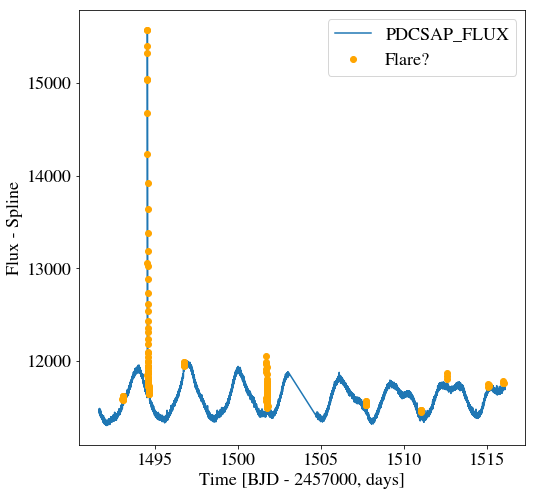

In [27]:
fig, axes = plt.subplots(figsize=(8,8))
axes.plot(time, flux, label='PDCSAP_FLUX')
axes.set_xlabel('Time [BJD - 2457000, days]')
axes.set_ylabel('Flux - Spline')

for idx in range(len((istart_i))):
    l = 'Flare?' if idx == 0 else '_nolabel_'
    axes.plot(time[istart_i[idx]:istop_i[idx]], flux[istart_i[idx]:istop_i[idx]], 'o', color='orange', label=l)
    
axes.legend()

In [29]:
# Lets try this with more conservative parameters
istart_i, istop_i = FINDflare(flux-spline, error, avg_std=True, N2=5)

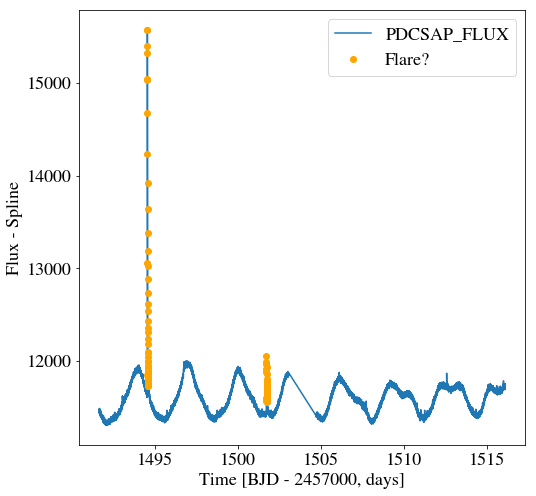

In [30]:
fig, axes = plt.subplots(figsize=(8,8))
axes.plot(time, flux, label='PDCSAP_FLUX')
axes.set_xlabel('Time [BJD - 2457000, days]')
axes.set_ylabel('Flux - Spline')

for idx in range(len((istart_i))):
    l = 'Flare?' if idx == 0 else '_nolabel_'
    axes.plot(time[istart_i[idx]:istop_i[idx]], flux[istart_i[idx]:istop_i[idx]], 'o', color='orange', label=l)
    
axes.legend()